# Unified Model with Multiple Strategic Agents: Strategic Agent-Specific Message Weights (Symmetric Network, Offset Agendas)

James Yu, 19 November 2022

NOTE: some of the graphs have angular truncations in them because of a precision limit with the solver in order for the code to run faster. Most of these are actually smooth instead of angular if the precision limit is made more precise.

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def M(K, B, R, L, delta):
    """Computes M_{t-1} given B_l \forall l, K_t^l \forall l, 
        R_l \forall l, number of strategic agents L, and delta."""
    # handle the generic structure first, with the correct pairings:
    base = [[B[l_prime].T @ K[l_prime] @ B[l] for l in range(L)] for l_prime in range(L)]
    # then change the diagonals to construct M_{t-1}:
    for l in range(L): base[l][l] = B[l].T @ K[l] @ B[l] + R[l]/delta
    return np.block(base)

def H(B, K, A, L):
    """Computes H_{t-1} given B_l \forall l, K_t^l \forall l, 
        A, and number of strategic agents L."""
    return np.concatenate(tuple(B[l].T @ K[l] @ A for l in range(L)), axis = 0)

def C_l(A, B, K, k, h, L, c, x, n):
    """Computes C_{t-1}^h (displayed as C_{t-1}^l) given A, B_l \forall l, K_t^l \forall l, 
        k_t^l \forall l, a specific naive agent h, number of strategic agents L, 
        c_l \forall l, x_l \forall l, and number of naive agents n"""
    return np.concatenate(tuple(B[l].T @ K[l] @ A @ ((x[h] - x[l]) * np.ones((n, 1))) 
                           + B[l].T @ K[l] @ c[l] 
                           + 0.5 * B[l].T @ k[l].T for l in range(L)), axis = 0)

def E(M_, H_):
    """Computes the generic E_{t-1} given M_{t-1} and H_{t-1}."""
    return np.linalg.inv(M_) @ H_

def F(M_, C_l_, l, n):
    """Computes F_{t-1}^l given M_{t-1}, C_{t-1}^l, 
       specific naive agent l and number of naive agents n."""
    return (np.linalg.inv(M_) @ C_l_)[l*n:(l+1)*n, :] # e.g. l = 0 gives ln = 0, l = 1 gives ln = n, etc

def G(A, B, E_, L, n):
    """Computes the generic G_{t-1} given A, B_l \forall l, 
        E_{t-1}, number of strategic agents L, and number of naive agents n."""
    return A - sum([B[l] @ E_[l*n:(l+1)*n, :] for l in range(L)])
    
def g_l(B, E_, h, x, F_, L, n, c):
    """Computes g_{t-1}^l given B_l \forall l, E_{t-1}^l, 
        a particular naive agent h, x_l \forall l, F_{t-1}^l \forall l, 
        number of strategic agents L, number of naive agents n, and c_h."""
    return - sum([B[l] @ (E_[l*n:(l+1)*n, :] @ ((x[h] - x[l]) * np.ones((n, 1))) + F_[l]) for l in range(L)]) + c[h]

In [3]:
def K_t_minus_1(Q, K, E_, R, G_, L, delta, n):
    return [Q[l] + E_[l*n:(l+1)*n, :].T @ R[l] @ E_[l*n:(l+1)*n, :] 
            + delta * G_.T @ K[l] @ G_ for l in range(L)]

def k_t_minus_1(K, k, G_, g, E_, F_, R, L, delta, n):
    return [2*delta* g[l].T @ K[l] @ G_ + delta * k[l] @ G_ 
            + 2 * F_[l].T @ R[l] @ E_[l*n:(l+1)*n, :] for l in range(L)]

def kappa_t_minus_1(K, k, kappa, g_, F_, R, L, delta):            
    return [-delta * (g_[l].T @ K[l] @ g_[l] + k[l] @ g_[l] - kappa[l]) 
            - (F_[l].T @ R[l] @ F_[l]) for l in range(L)]

In [4]:
def should_terminate(bundles, eps):
    return all([np.allclose(b[0], b[1], rtol = eps, atol = eps) for b in bundles])

def solve(K_t, k_t, kappa_t, A, B, delta, n, L, Q, R, x, c, tol):
    historical_K = [K_t]
    historical_k = [k_t]
    historical_kappa = [kappa_t]
    eps = np.sqrt(np.finfo(np.float64).eps)
    while True:
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        K_new = K_t_minus_1(Q, K_t, E_, R, G_, L, delta, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        k_new = k_t_minus_1(K_t, k_t, G_, g, E_, F_, R, L, delta, n)
        kappa_new = kappa_t_minus_1(K_t, k_t, kappa_t, g, F_, R, L, delta)
        historical_K.insert(0, K_new)
        historical_k.insert(0, k_new)
        historical_kappa.insert(0, kappa_new)
        if should_terminate([(K_t, K_new), (k_t, k_new), (kappa_t, kappa_new)], eps):
            return historical_K[0], historical_k[0], historical_kappa[0]
        K_t = K_new
        k_t = k_new
        kappa_t = kappa_new

In [5]:
def optimal(X_init, K_ss, k_ss, A, B, delta, n, L, Q, R, x, c, eps):
    X_t = [a.copy() for a in X_init]
    xs = defaultdict(list)
    for l in range(L):
        xs[l].append(X_t[l])
        
    rs = defaultdict(list)
    payoffs = defaultdict(list)
    payoff = defaultdict(int)
    
    M_ = M(K_ss, B, R, L, delta)
    H_ = H(B, K_ss, A, L)
    E_ = E(M_, H_)
    G_ = G(A, B, E_, L, n)
    F_ = [F(M_, C_l(A, B, K_ss, k_ss, l, L, c, x, n), l, n) for l in range(L)]
    g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
    
    i = 0
    while True:
        for l in range(L):
            # TODO: special code for finite horizon needs a terminal time T term
            Y_new = -1 * E_[l*n:(l+1)*n, :] @ X_t[l] - F(M_, C_l(A, B, K_ss, k_ss, l, L, c, x, n), l, n)
            rs[l].append(Y_new)
            payoff[l] += (-1 * delta**i * (X_t[l].T @ Q[l] @ X_t[l])).item() + (-1 * delta**i * (Y_new.T @ R[l] @ Y_new)).item()
            payoffs[l].append(payoff[l])
            X_new = G_ @ X_t[l] + g[l]
            xs[l].append(X_new)
            if l == L - 1 and np.allclose(X_t[l], X_new, rtol = eps, atol = eps):
                return xs, rs, payoffs
            X_t[l] = X_new 
        i += 1
        
    return xs, rs, payoffs

In [6]:
def run_simulation(b1, b2, a1, a2, delta = 0.9, c = 200, X_0_1 = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T, symmetric = True, print_ = True, tol = np.sqrt(np.finfo(np.float64).eps)):
    if symmetric:
        A = np.array([ # stubborn
            [0.9, 0.07, 0.03],
            [0.07, 0.58, 0.35],
            [0.03, 0.35, 0.62]
        ])
        if print_: print("SYMMETRIC NETWORK")
    else:
        A = np.array([ # asymmetric
            [0.6, 0.3, 0.1],
            [0.4, 0.1, 0.5],
            [0.5, 0.2, 0.3]
        ])
        if print_: print("ASYMMETRIC NETWORK")
    X_0 = [X_0_1 - b1, X_0_1 - b2]
    n = 3 # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [c * np.identity(n), c * np.identity(n)] # message cost R = cI_n for some c under the new notation
    B = [a1 * np.identity(n), a2 * np.identity(n)] # B^l = a_l I_n
    x = [b1, b2] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    
    K_ss, k_ss, kappa_ss = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol)
    xs, rs, payoffs = optimal(X_0, K_ss, k_ss, A, B, delta, n, L, Q, R, x, c, tol)
    if print_:
        print("Steady-State Opinions:")
        print(xs[0][-1] + b1)
        print("Average of agendas:")
        print((b1+b2)/2)
        print()
        print("K^* (1, 2):")
        print(K_ss[0])
        print(K_ss[1])
        print()
        print("k^* (1, 2):")
        print(k_ss[0])
        print(k_ss[1])
        print()
        print("kappa^* (1, 2):")
        print(kappa_ss[0])
        print(kappa_ss[1])
    if print_ == False:
        return xs[0][-1] + b1

## Vary $a_1$

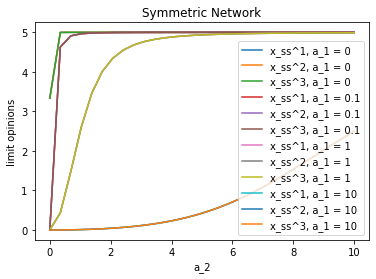

In [7]:
grid = np.linspace(0, 10, 30)
base_4 = [run_simulation(0, 5, 0, g, print_ = False, tol = 10**-5) for g in grid]
plt.plot(grid, [b[0][0] for b in base_4], label = "x_ss^1, a_1 = 0")
plt.plot(grid, [b[1][0] for b in base_4], label = "x_ss^2, a_1 = 0")
plt.plot(grid, [b[2][0] for b in base_4], label = "x_ss^3, a_1 = 0")
base_3 = [run_simulation(0, 5, 0.1, g, print_ = False) for g in grid]
plt.plot(grid, [b[0][0] for b in base_3], label = "x_ss^1, a_1 = 0.1")
plt.plot(grid, [b[1][0] for b in base_3], label = "x_ss^2, a_1 = 0.1")
plt.plot(grid, [b[2][0] for b in base_3], label = "x_ss^3, a_1 = 0.1")
base_1 = [run_simulation(0, 5, 1, g, print_ = False) for g in grid]
plt.plot(grid, [b[0][0] for b in base_1], label = "x_ss^1, a_1 = 1")
plt.plot(grid, [b[1][0] for b in base_1], label = "x_ss^2, a_1 = 1")
plt.plot(grid, [b[2][0] for b in base_1], label = "x_ss^3, a_1 = 1")
base_2 = [run_simulation(0, 5, 10, g, print_ = False) for g in grid]
plt.plot(grid, [b[0][0] for b in base_2], label = "x_ss^1, a_1 = 10")
plt.plot(grid, [b[1][0] for b in base_2], label = "x_ss^2, a_1 = 10")
plt.plot(grid, [b[2][0] for b in base_2], label = "x_ss^3, a_1 = 10")
plt.xlabel("a_2")
plt.ylabel("limit opinions")
plt.legend()
plt.title("Symmetric Network")
plt.show()

## Vary $\delta$

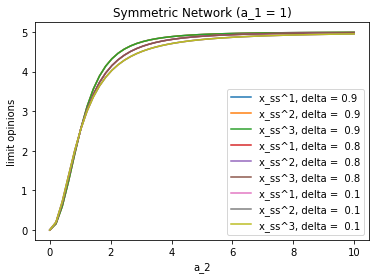

In [8]:
grid = np.linspace(0, 10, 50)
base_1 = [run_simulation(0, 5, 1, g, print_ = False) for g in grid]
base_2 = [run_simulation(0, 5, 1, g, delta = 0.8, print_ = False) for g in grid]
base_3 = [run_simulation(0, 5, 1, g, delta = 0.1, print_ = False) for g in grid]
plt.plot(grid, [b[0][0] for b in base_1], label = "x_ss^1, delta = 0.9")
plt.plot(grid, [b[1][0] for b in base_1], label = "x_ss^2, delta =  0.9")
plt.plot(grid, [b[2][0] for b in base_1], label = "x_ss^3, delta =  0.9")
plt.plot(grid, [b[0][0] for b in base_2], label = "x_ss^1, delta =  0.8")
plt.plot(grid, [b[1][0] for b in base_2], label = "x_ss^2, delta =  0.8")
plt.plot(grid, [b[2][0] for b in base_2], label = "x_ss^3, delta =  0.8")
plt.plot(grid, [b[0][0] for b in base_3], label = "x_ss^1, delta =  0.1")
plt.plot(grid, [b[1][0] for b in base_3], label = "x_ss^2, delta =  0.1")
plt.plot(grid, [b[2][0] for b in base_3], label = "x_ss^3, delta =  0.1")
plt.xlabel("a_2")
plt.ylabel("limit opinions")
plt.legend()
plt.title("Symmetric Network (a_1 = 1)")
plt.show()

## Vary $c$

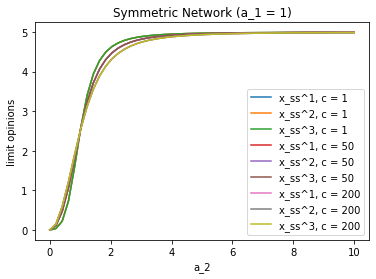

In [9]:
grid = np.linspace(0, 10, 50)
base_1 = [run_simulation(0, 5, 1, g, c = 1, print_ = False) for g in grid]
base_2 = [run_simulation(0, 5, 1, g, c = 50, print_ = False) for g in grid]
base_3 = [run_simulation(0, 5, 1, g, c = 200, print_ = False) for g in grid]
plt.plot(grid, [b[0][0] for b in base_1], label = "x_ss^1, c = 1")
plt.plot(grid, [b[1][0] for b in base_1], label = "x_ss^2, c = 1")
plt.plot(grid, [b[2][0] for b in base_1], label = "x_ss^3, c = 1")
plt.plot(grid, [b[0][0] for b in base_2], label = "x_ss^1, c = 50")
plt.plot(grid, [b[1][0] for b in base_2], label = "x_ss^2, c = 50")
plt.plot(grid, [b[2][0] for b in base_2], label = "x_ss^3, c = 50")
plt.plot(grid, [b[0][0] for b in base_3], label = "x_ss^1, c = 200")
plt.plot(grid, [b[1][0] for b in base_3], label = "x_ss^2, c = 200")
plt.plot(grid, [b[2][0] for b in base_3], label = "x_ss^3, c = 200")
plt.xlabel("a_2")
plt.ylabel("limit opinions")
plt.legend()
plt.title("Symmetric Network (a_1 = 1)")
plt.show()

## Vary $X_0$:

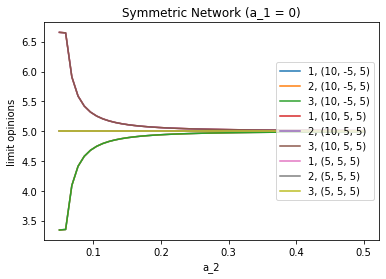

In [10]:
grid = np.linspace(0.05, 0.5, 50)
base_1 = [run_simulation(0, 5, 0, g, X_0_1 = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T, print_ = False, tol = 10**-4) for g in grid]
base_2 = [run_simulation(0, 5, 0, g, X_0_1 = np.array([[10.0, 5.0, 5.0]], ndmin = 2).T, print_ = False, tol = 10**-4) for g in grid]
base_3 = [run_simulation(0, 5, 0, g, X_0_1 = np.array([[5.0, 5.0, 5.0]], ndmin = 2).T, print_ = False, tol = 10**-4) for g in grid]
plt.plot(grid, [b[0][0] for b in base_1], label = "1, (10, -5, 5)")
plt.plot(grid, [b[1][0] for b in base_1], label = "2, (10, -5, 5)")
plt.plot(grid, [b[2][0] for b in base_1], label = "3, (10, -5, 5)")
plt.plot(grid, [b[0][0] for b in base_2], label = "1, (10, 5, 5)")
plt.plot(grid, [b[1][0] for b in base_2], label = "2, (10, 5, 5)")
plt.plot(grid, [b[2][0] for b in base_2], label = "3, (10, 5, 5)")
plt.plot(grid, [b[0][0] for b in base_3], label = "1, (5, 5, 5)")
plt.plot(grid, [b[1][0] for b in base_3], label = "2, (5, 5, 5)")
plt.plot(grid, [b[2][0] for b in base_3], label = "3, (5, 5, 5)")
plt.xlabel("a_2")
plt.ylabel("limit opinions")
plt.legend(loc = "right")
plt.title("Symmetric Network (a_1 = 0)")
plt.show()

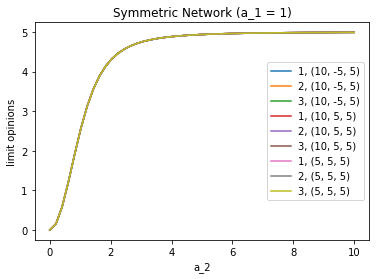

In [11]:
grid = np.linspace(0, 10, 50)
base_1 = [run_simulation(0, 5, 1, g, X_0_1 = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T, print_ = False, tol = 10**-5) for g in grid]
base_2 = [run_simulation(0, 5, 1, g, X_0_1 = np.array([[10.0, 5.0, 5.0]], ndmin = 2).T, print_ = False, tol = 10**-5) for g in grid]
base_3 = [run_simulation(0, 5, 1, g, X_0_1 = np.array([[5.0, 5.0, 5.0]], ndmin = 2).T, print_ = False, tol = 10**-5) for g in grid]
plt.plot(grid, [b[0][0] for b in base_1], label = "1, (10, -5, 5)")
plt.plot(grid, [b[1][0] for b in base_1], label = "2, (10, -5, 5)")
plt.plot(grid, [b[2][0] for b in base_1], label = "3, (10, -5, 5)")
plt.plot(grid, [b[0][0] for b in base_2], label = "1, (10, 5, 5)")
plt.plot(grid, [b[1][0] for b in base_2], label = "2, (10, 5, 5)")
plt.plot(grid, [b[2][0] for b in base_2], label = "3, (10, 5, 5)")
plt.plot(grid, [b[0][0] for b in base_3], label = "1, (5, 5, 5)")
plt.plot(grid, [b[1][0] for b in base_3], label = "2, (5, 5, 5)")
plt.plot(grid, [b[2][0] for b in base_3], label = "3, (5, 5, 5)")
plt.xlabel("a_2")
plt.ylabel("limit opinions")
plt.legend(loc = "right")
plt.title("Symmetric Network (a_1 = 1)")
plt.show()